In [1]:
import pandas as pd

df = pd.read_csv("Tweets.csv")
df.shape

(30640, 15)

In [2]:
df.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                  16596
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          30600
name                                0
negativereason_gold             30608
retweet_count                       0
text                                0
tweet_coord                     29621
tweet_created                       0
tweet_location                   6761
user_timezone                    4953
dtype: int64

In [3]:
# removing unnecessary columns
df = df.drop(columns=["tweet_id", "airline", "name", "airline_sentiment_gold", "negativereason_gold", "tweet_coord", "tweet_created", "retweet_count", "user_timezone", "tweet_location"])

In [4]:
df
# airline-sentiment is the target variable

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,text
0,neutral,1.0000,NaN,NaN,@VirginAmerica What @dhepburn said.
1,positive,0.3486,NaN,0.0000,@VirginAmerica plus you've added commercials t...
2,neutral,0.6837,NaN,NaN,@VirginAmerica I didn't today... Must mean I n...
3,negative,1.0000,Bad Flight,0.7033,@VirginAmerica it's really aggressive to blast...
4,negative,1.0000,Can't Tell,1.0000,@VirginAmerica and it's a really big bad thing...
...,...,...,...,...,...
30635,neutral,0.6318,NaN,0.0000,Nothing much to report.
30636,positive,0.6951,NaN,0.0000,Thank you for the awesome support!
30637,positive,0.8501,NaN,0.0000,Thank you for the awesome support!
30638,negative,0.7317,Damaged Luggage,0.9054,So disappointed with the delay.


In [5]:
df = df.drop(columns=["negativereason", "negativereason_confidence"])
df

,airline_sentiment,airline_sentiment_confidence,text
0,neutral,1.0000,@VirginAmerica What @dhepburn said.
1,positive,0.3486,@VirginAmerica plus you've added commercials t...
2,neutral,0.6837,@VirginAmerica I didn't today... Must mean I n...
3,negative,1.0000,@VirginAmerica it's really aggressive to blast...
4,negative,1.0000,@VirginAmerica and it's a really big bad thing...
...,...,...,...
30635,neutral,0.6318,Nothing much to report.
30636,positive,0.6951,Thank you for the awesome support!
30637,positive,0.8501,Thank you for the awesome support!
30638,negative,0.7317,So disappointed with the delay.


In [6]:
df

,airline_sentiment,airline_sentiment_confidence,text
0,neutral,1.0000,@VirginAmerica What @dhepburn said.
1,positive,0.3486,@VirginAmerica plus you've added commercials t...
2,neutral,0.6837,@VirginAmerica I didn't today... Must mean I n...
3,negative,1.0000,@VirginAmerica it's really aggressive to blast...
4,negative,1.0000,@VirginAmerica and it's a really big bad thing...
...,...,...,...
30635,neutral,0.6318,Nothing much to report.
30636,positive,0.6951,Thank you for the awesome support!
30637,positive,0.8501,Thank you for the awesome support!
30638,negative,0.7317,So disappointed with the delay.


In [7]:
# data cleaning, may help improve accuracy
for i in range(len(df)):
    text = df.loc[i, "text"]
    words = text.split(" ")
    
    cleaned_words = [word for word in words if word and word[0] not in ["@", "#"]]
    cleaned = " ".join(cleaned_words)
    df.loc[i, "text"] = cleaned
df

,airline_sentiment,airline_sentiment_confidence,text
0,neutral,1.0000,What said.
1,positive,0.3486,plus you've added commercials to the experienc...
2,neutral,0.6837,I didn't today... Must mean I need to take ano...
3,negative,1.0000,"it's really aggressive to blast obnoxious ""ent..."
4,negative,1.0000,and it's a really big bad thing about it
...,...,...,...
30635,neutral,0.6318,Nothing much to report.
30636,positive,0.6951,Thank you for the awesome support!
30637,positive,0.8501,Thank you for the awesome support!
30638,negative,0.7317,So disappointed with the delay.


In [8]:
# converting text into numerical vectors
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, precision_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional, Dropout, GRU, BatchNormalization, Conv1D, MaxPooling1D
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l2
from sklearn.utils import class_weight
import tensorflow.keras

In [9]:
label_encoder = LabelEncoder()

x = df["text"]
y = df["airline_sentiment"]
y = label_encoder.fit_transform(y)

print(label_encoder.classes_)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

['negative' 'neutral' 'positive']


In [10]:
# tokenizing
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(x_train)

x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)

# padding sequences to enseure equal length in all the texts
max_length = 100
x_train_pad = pad_sequences(x_train_seq, maxlen=max_length, padding="post", truncating="post")
x_test_pad = pad_sequences(x_test_seq, maxlen=max_length, padding="post", truncating="post")

In [11]:
# making the neural network
'''
working with : text
does order matter : yes

text -> need to use embeddings/tokenization

does model need to remember words :
    yes -> LSTM/GRU
    no -> dense layers

simple problem? => embedding + dense layer
complex problem? => LSTM + dense layer

here we can use embeddings because we need to establish relationship between words, 'good' and 'great' are similar in meaning

deciding layers:
    firstly, words (now integers) must be converted into vectors. hence, layer 1 = embedding
    secondly, vectors have to be put into an lstm to work on it. hence, layer 2 = LSTM
    lastly, we have to select one out of 3 outputs. hence, layer 3 = dense 
'''

model = Sequential([
    Embedding(input_dim=10000, output_dim=50, mask_zero=True),
    Bidirectional(GRU(10, recurrent_dropout=0.3, recurrent_regularizer=l2(0.02))),
    BatchNormalization(),
    Dense(8, activation="relu", kernel_regularizer=l2(0.02)),
    Dropout(0.4),
    Dense(6, activation='relu'),
    Dropout(0.3),
    Dense(3, activation="softmax")
])

In [12]:
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [13]:
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=1, min_lr=1e-5, verbose=1
)

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights = dict(enumerate(class_weights))
print(class_weights)

history = model.fit(x_train_pad, y_train, epochs=20, batch_size=64, validation_split=0.2, callbacks=[early_stopping, reduce_lr], class_weight=class_weights)

{0: np.float64(0.7061941803514837), 1: np.float64(1.2026297713668923), 2: np.float64(1.3289958794187813)}
Epoch 1/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 36s 99ms/step - accuracy: 0.4481 - loss: 1.4947 - val_accuracy: 0.6755 - val_loss: 1.1992 - learning_rate: 5.0000e-04
Epoch 2/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 30s 97ms/step - accuracy: 0.6020 - loss: 0.9832 - val_accuracy: 0.8234 - val_loss: 0.7230 - learning_rate: 5.0000e-04
Epoch 3/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 30s 97ms/step - accuracy: 0.7214 - loss: 0.7420 - val_accuracy: 0.8366 - val_loss: 0.5550 - learning_rate: 5.0000e-04
Epoch 4/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 29s 96ms/step - accuracy: 0.7783 - loss: 0.6195 - val_accuracy: 0.8395 - val_loss: 0.4891 - learning_rate: 5.0000e-04
Epoch 5/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 35s 115ms/step - accuracy: 0.8060 - loss: 0.5530 - val_accuracy: 0.8448 - val_loss: 0.4493 - learning_rate: 5.0000e-04
Epoch 6/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.8290 - loss: 0.4918
Epoch 6: Reduce

In [14]:
results = model.evaluate(x_test_pad, y_test, verbose=0)
print(f"[test loss, test accuracy]: {results}")

y_pred = np.argmax(model.predict(x_test_pad), axis=1)

[test loss, test accuracy]: [0.4432408809661865, 0.8443211317062378]
192/192 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step


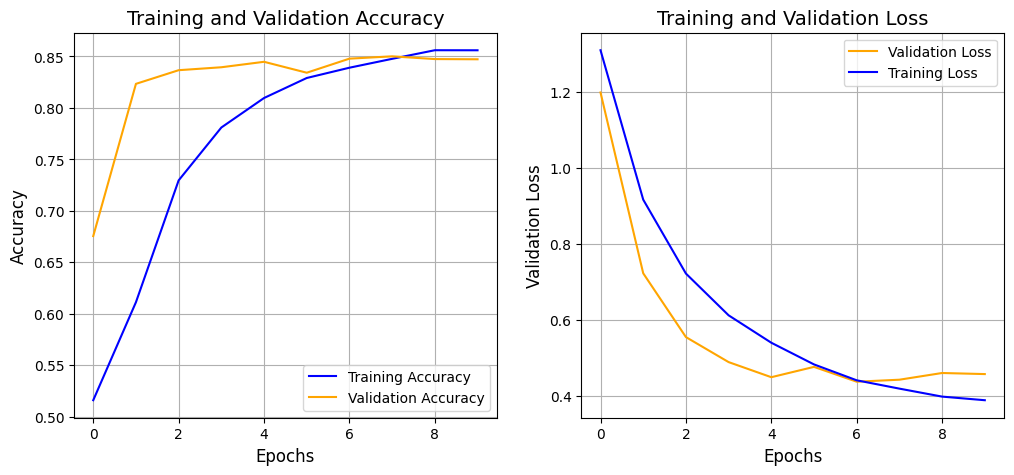

In [15]:
# visualization
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history["val_loss"], label="Validation Loss", color="orange")
plt.plot(history.history["loss"], label="Training Loss", color="blue")
plt.title("Training and Validation Loss", fontsize=14)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Validation Loss", fontsize=12)
plt.legend()
plt.grid(True)

In [16]:
print("y_pred shape:", y_pred.shape)
print("y_test shape:", y_test.shape)
print("Sample y_pred:", y_pred[:5])
print("Sample y_test:", y_test[:5])

print(classification_report(y_test, y_pred))

y_pred shape: (6128,)
y_test shape: (6128,)
Sample y_pred: [0 0 2 1 1]
Sample y_test: [0 0 2 2 1]
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      2963
           1       0.83      0.76      0.79      1643
           2       0.78      0.89      0.83      1522

    accuracy                           0.84      6128
   macro avg       0.83      0.84      0.83      6128
weighted avg       0.85      0.84      0.84      6128



<Axes: >

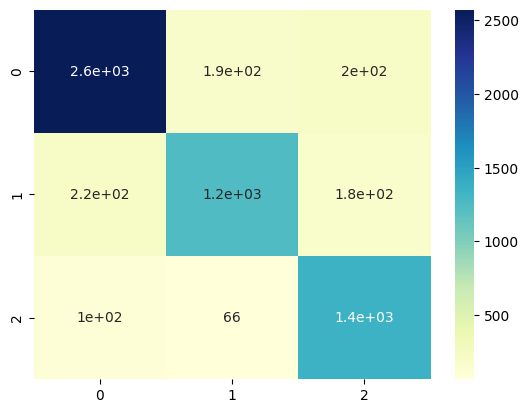

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='YlGnBu')

In [18]:
text = [
    "The service was so ok that i had to get up from my chair and go to the air hostess and get water, like why would i have to do that when its not my job",
    "Why would anyone choose this airline when i was having such a nice time even though the seat was bad",
    "the plane felt like it would crash",
    "it was decent, what more can one say",
    "it was ok",
    "can do better",
    "someone needs to get better in their team, else i see no future for this airline"
    ]
seq = tokenizer.texts_to_sequences(text)
padded = pad_sequences(seq, maxlen=max_length)
y_pred_prob = model.predict(padded)
y_pred_class = y_pred_prob.argmax(axis=1)

label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}

pred_labels = list(map(label_map.get, y_pred_class))

for sentence, label, probs in zip(text, pred_labels, y_pred_prob):
    print(f"\nText: {sentence}")
    print(f"Prediction: {label}")
    print(f"Class Probabilities: {probs}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step

Text: The service was so ok that i had to get up from my chair and go to the air hostess and get water, like why would i have to do that when its not my job
Prediction: Negative
Class Probabilities: [0.68043894 0.1852288  0.13433227]

Text: Why would anyone choose this airline when i was having such a nice time even though the seat was bad
Prediction: Negative
Class Probabilities: [0.89559436 0.09292254 0.01148315]

Text: the plane felt like it would crash
Prediction: Negative
Class Probabilities: [0.68777055 0.18295121 0.1292783 ]

Text: it was decent, what more can one say
Prediction: Negative
Class Probabilities: [0.75730765 0.18207437 0.06061801]

Text: it was ok
Prediction: Neutral
Class Probabilities: [0.03458917 0.9635526  0.00185824]

Text: can do better
Prediction: Neutral
Class Probabilities: [0.05538477 0.94294983 0.00166545]

Text: someone needs to get better in their team, else i see no future for this airline
Prediction: Negative
Cla

In [19]:
model.save("sentiment.keras")